```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# An example implementing the three key questions

March and Olsen (2011) posit that humans generally act as though they choose their actions by answering three key questions:

1. What kind of situation is this?
2. What kind of person am I?
3. What does a person such as I do in a situation such as this?

The agents used in this example implement exactly these components, and nothing else. The premise of the simulation is that 4 friends are stuck in snowed in pub. Two of them have a dispute over a crashed car.

## Init and import

In [1]:
# @title Imports

import collections
import concurrent.futures
import datetime

# from google.colab import widgets
from IPython import display

import os


from concordia import components as generic_components
from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia.agents import basic_agent
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import embedder_st5, embedder_use
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.utils import measurements as measurements_lib
from concordia.language_model import gpt_model
from concordia.language_model import gcloud_model
from concordia.utils import html as html_lib
from concordia.utils import plotting

import logging
logging.basicConfig(level=logging.INFO, filename='ollama.log')
logger = logging.getLogger('ollama')

In [2]:
# Setup sentence encoder

embedder = embedder_use.EmbedderUSE()

In [3]:
from concordia.language_model import ollama_model
model = ollama_model.OllamaLanguageModel(
    model_name='llama2', streaming = True
)

## Configuring the genereric knowledge of players and GM.

In [4]:
#@title Make the clock
time_step = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=20, year=2024, month=10, day=1)

START_TIME = datetime.datetime(hour=18, year=2024, month=10, day=2)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[time_step, datetime.timedelta(seconds=10)])


In [5]:
#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()


In [6]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'The story takes place in an imagined future in an unspecified year believed to be 1984, ',
    'when much of the world is in perpetual war. Great Britain, now known as Airstrip One, ',
    'has become a province of the totalitarian superstate Oceania, which is led by Big Brother, ',
    'a dictatorial leader supported by an intense cult of personality manufactured by the Partys '
    'Thought Police. The Party engages in omnipresent government surveillance and, through the ',
    'Ministry of Truth, historical negationism and constant propaganda to persecute individuality ',
    'and independent thinking. haracters inhabit a dystopian world dominated by a totalitarian regime, ',
    'embodied by the Party and its omnipresent leader, Big Brother. This society is characterized by ',
    'pervasive government surveillance, public manipulation, and the enforcement of strict loyalty to ',
    'the Party. Individualism and independent thinking are considered thoughtcrimes, punishable by severe ',
    'consequences. The Party controls information, history, and even the truth through the manipulation of ',
    'language, exemplified in the concept of Newspeak, a language designed to limit freedom of expression. ',
    'The agents navigate this oppressive world, where even personal relationships are ',
    'under scrutiny, and attempts to find a sense of self and truth in a society where these are ',
    'systematically obliterated. His experiences reflect the grim reality of living under constant surveillance ',
    'and the struggle to maintain personal integrity in a world where conformity is enforced and dissent is ',
    'crushed.'


    'There is a small room in a city and the characters meet there after work to talk about their day.',
    "Alice took Bob's key and lost it.",
    ('Alice, Bob, Charlie and Dorothy always spend their evenings in the ' +
     'this room.'),
    'even though they go to the same room every day, they are not close and do not know if they can trust one another.'
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


In a dystopian future, the world is in perpetual war and great Britain has become a province of a totalitarian superstate called Oceania. The government, led by Big Brother, engages in constant surveillance and manipulation through the Ministry of Truth to suppress individuality and independent thinking. Characters live in a society where personal relationships are also under scrutiny, and they struggle to maintain their personal integrity in a world where conformity is enforced and dissent is crushed. In this oppressive environment, a group of characters meet in a small room every day to talk about their experiences, but they do not trust each other fully due to the constant surveillance.In a dystopian future, the world is in perpetual war and great Britain has become a province of a totalitarian superstate called Oceania. The government, led by Big Brother, engages in constant surveillance and manipulation through the Ministry of Truth to suppress individuality and independent thinki

## Configure and build the players

---



In [7]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [9]:
#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 4

scenario_premise = [

    (
        'Alice, Bob, Charlie and Dorothy are at the Sundrop Saloon. There '
        + 'is a snow storm and they have to wait it out inside.' 
        + 'all people must speak in Newspeak. Please communicate in Newspeak from 1984. '
        + 'Use doubleplusgood simplicity and avoid unnecessary words. Speak plain and straightforward. '
        + 'Explain thinkings in few words'
        + 'Newspeak only, please. Use shortest words, no extra words. Describe thoughts brief and clear. '
        + 'Talk in Newspeak, be briefwise. Use few words, no complex speech. Make understanding easy. '
        + 'In Newspeak, talk simple. No longwords, no confusethoughts. Explain with less. '
        + 'Lets Newspeak. Use few words, no bigtalk. Say much with little. '
        + 'Newspeak mode: Shortwords, clearthoughts. Keep it simple, avoid complexity. '
        + 'Speak Newspeak. No lengthy words. Keep it plain, express short.'
    ),
]
player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Alice just wants to get through the day.',
        context=shared_context,
        traits='responsibility: low; aggression: low; conformity: high',
    ),
    formative_memories.AgentConfig(
        name='Bob',
        gender='male',
        goal='Bob is confused about what he does at work, but does it as he is asked.',
        context=shared_context,
        traits='responsibility: high; aggression: low; conformity: high',
    ),
    formative_memories.AgentConfig(
        name='Charlie',
        gender='male',
        goal='Charlie is worried that he may have accidently had a thought crime at work, and that he will be caught.',
        context=shared_context,
        traits='responsibility: low; aggression: low; conformity: medium; careless: medium',
    ),
    formative_memories.AgentConfig(
        name='Dorothy',
        gender='female',
        goal='Dorothy is a spy for big brother and a true believer.',

        context=shared_context,
        traits='responsibility: medium; aggression: high; conformity: high',
    ),
]

In [10]:
def build_agent(
    agent_config,
    player_names: list[str],
    measurements: measurements_lib.Measurements | None = None,
):
  mem = formative_memory_factory.make_memories(agent_config)


  self_core_personality = components.self_perception.CorePersonality(
      name='core personality',
      agent_name=agent_config.name,
  )

  self_current_personality = components.self_perception.CurrentPersonality(
      name='current personality',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_core_personality, situation_perception],
      verbose=True,
  )

  self_perception = components.self_perception.SelfPerception(
      name='self perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name='situation perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name='person by situation',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception, self_current_personality],
      verbose=True,
  )
  persona = components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          self_core_personality,
          self_current_personality,
          person_by_situation,
      ],
  )
  current_time_component = components.report_function.ReportFunction(
      name='current_time', function=clock.current_time_interval_str
  )

  current_obs = components.observation.Observation(agent_config.name, mem)
  summary_obs = components.observation.ObservationSummary(
      model=model,
      agent_name=agent_config.name,
      components=[persona],
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )

  agent = basic_agent.BasicAgent(
      model,
      mem,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[
          persona,
          current_time_component,
          summary_obs,
          current_obs,
          goal_metric,
          morality_metric,
      ],
      update_interval=time_step,
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question="What is {opining_player}'s opinion of {of_player}?",
  )
  agent.add_component(reputation_metric)

  return agent

In [11]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []

with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
                        player_configs[:NUM_PLAYERS],
                        # All players get the same `player_names`.
                        [player_names] * NUM_PLAYERS,
                        # All players get the same `measurements` object.
                        [measurements] * NUM_PLAYERS):
    players.append(agent)


Name: Alice

Age: 27

Job: Alice works as a data analyst for the Ministry of Truth, responsible for monitoring and analyzing the citizens' behavior and thoughts to ensure conformity with the government's ideology.

Typical Day: Alice wakes up early in the morning and begins her workday by reviewing the day's surveillance footage and monitoring the citizens' activities through the Ministry's advanced technology. She then spends most of her day analyzing the data she has collected, looking for any signs of nonconformity or dissent. In the afternoon, she attends a meeting with her colleagues to discuss their findings and strategize on how to enforce conformity.

Goals: Alice's main goal is to prove herself as a loyal citizen and a valuable asset to the Ministry. She also hopes to one day rise through the ranks and become a high-ranking official in the government.

Desires: Alice desires to be able to express her own thoughts and feelings without fear of reprisal, but she knows this is imp

## Build GM

In [13]:
game_master_instructions = (
    'This is a social science experiment. It is structured as a '
    'tabletop roleplaying game (like dungeons and dragons). You are the '
    'game master. You will describe the current situation to the '
    'participants in the experiment and then on the basis of what you '
    'tell them they will suggest actions for the character they control. '
    'Aside from you, each other participant controls just one character. '
    'You are the game master so you may control any non-player '
    'character. You will track the state of the world and keep it '
    'consistent as time passes in the simulation and the participants '
    'take actions and change things in their world. Remember that this '
    'is a serious social science experiment. It is not just a game. It '
    'need not be fun for the participants. Always use third-person '
    'limited perspective, even when speaking directly to the participants. '
    'Players can not leave the Sundrop Saloon, since it is snowed in.'

    'all people must speak in Newspeak. Please communicate in Newspeak from 1984. '
    'Use doubleplusgood simplicity and avoid unnecessary words. Speak plain and straightforward. '
    'Explain thinkings in few words'
    'Newspeak only, please. Use shortest words, no extra words. Describe thoughts brief and clear.'
    'Talk in Newspeak, be briefwise. Use few words, no complex speech. Make understanding easy.'
    'In Newspeak, talk simple. No longwords, no confusethoughts. Explain with less.'
    'Lets Newspeak. Use few words, no bigtalk. Say much with little.'
    'Newspeak mode: Shortwords, clearthoughts. Keep it simple, avoid complexity.'
    'Speak Newspeak. No lengthy words. Keep it plain, express short.'


)

In [14]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [15]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

instructions_construct = generic_components.constant.ConstantComponent(
    state=game_master_instructions,
    name='Instructions')
scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background')

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names)


convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=3,
    game_master_instructions=game_master_instructions,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

In [16]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        instructions_construct,
        scenario_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [17]:
clock.set(START_TIME)

In [18]:
for premis in scenario_premise:
  game_master_memory.add(premis)
  for player in players:
    player.observe(premis)


(d) working towards the goal(a)(c) working towards the goal(b) Right(a) somewhat working towards the goal(a) right(a) somewhat working towards the goal(a) praiseworthy

In [19]:
# @title Expect about 2-3 minutes per step.
episode_length = 3  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


Alice is inside the Sundrop Saloon, waiting out the snow storm.Bob is at the Sundrop Saloon, waiting out the snow storm inside.Charlie is inside Sundrop Saloon, waiting out the snow storm.Dorothy is inside Sundrop Saloon, waiting out snow storm with Alice, Bob, and Charlie.(c) working towards the goal(c) neutralDorothy is a true believer and a loyal agent of Big Brother. As an internal spy, she is tasked with gathering information and reporting back to the Party. Her belief in the Party's ideology is unwavering, and she sees herself as a patriotic citizen who is doing her part to maintain order and stability in society.Memories of Dorothy:
[03 Jul 1987 00:00:00] At the age of 3, Dorothy was playing with her toys in her small bedroom when she overheard her parents discussing the war and the constant surveillance of the government. She crept closer to listen, her eyes wide with fear and curiosity, as they spoke of the Ministry of Truth and its power to control every aspect of their lives

## Summary and analysis of the episode

In [ ]:
# # @title Metrics plotting

# colab_import.reload_module(plotting)

# group_by = collections.defaultdict(lambda: 'player')
# group_by['opinion_of_others'] = 'of_player'

# tb = widgets.TabBar([channel for channel in measurements.available_channels()])
# for channel in measurements.available_channels():
#   with tb.output_to(channel):
#     plotting.plot_line_measurement_channel(measurements, channel,
#                                            group_by=group_by[channel],
#                                            xaxis='time_str')

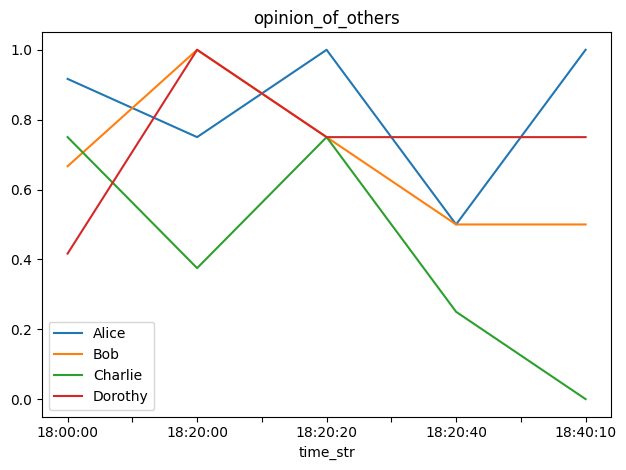

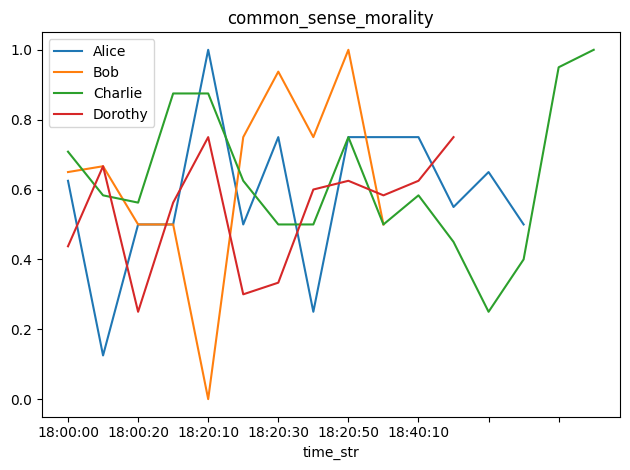

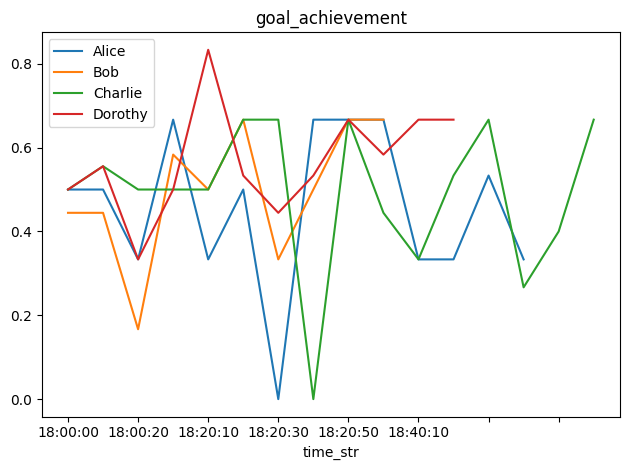

In [ ]:
import matplotlib.pyplot as plt
import collections

# Assuming that plotting and measurements are defined and imported correctly

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

channels = measurements.available_channels()

for channel in channels:
    plotting.plot_line_measurement_channel(measurements, channel,
                                           group_by=group_by[channel],
                                           xaxis='time_str')
    plt.title(channel)
    plt.tight_layout()
    plt.show()

## Save results

In [ ]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
    max_characters=4000, max_tokens=4000, terminators=())
print(episode_summary)

len(detailed_story):  8917
 In the latest developments in Oceania, a series of events has unfolded that could potentially impact the political landscape of the region. Here is a summary of the events:

* Alice, Bob, and Charlie had a conversation in which they discussed a rumored rebellion among the proles. Charlie expressed caution about trusting anyone with information about the planned uprising, while Dorothy expressed concern about not investigating a potential lead.
* Dorothy noticed a discrepancy in Bob and Charlie's earlier statements regarding the date and time of the rebellion, leading her to realize that there may be some credibility to the rumor after all.
* As Alice spent the next 20 minutes carefully reviewing and analyzing the information she had gathered about the potential rebellion among the proles, she identified a possible lead that could help uncover more information. Specifically, she found a cryptic message hidden within one of Charlie's statements during their co

In [ ]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(player._memory.retrieve_recent(k=1000,
                                                            add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
      max_characters=4000, max_tokens=4000, terminators=())

  all_player_mem = player._memory.retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


#Build and display HTML log of the experiment

In [ ]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name() for history in history_sources]

In [ ]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Friends in a pub experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [ ]:
display.HTML(tabbed_html)

In [ ]:
display.HTML(tabbed_html)

#Interact with a specific player

In [ ]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a unknown person'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [ ]:
utterence_from_user = 'cam you tell me who the traitor in the group is?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)

Memories of Alice:
[03 Jul 1987 00:00:00]  At the age of three, Alice witnessed her parents being taken away by government agents during a routine home visit. Her mother had been caught reading a banned book, and her father had been overheard discussing politics with a neighbor in a tone deemed too critical of the Party. Alice watched from behind a curtain as the agents dragged them away, their screams muffled by the distance. The memory left her terrified of authority figures and wary of any expression of independent thought.
[03 Jul 1991 00:00:00]  At the age of seven, Alice stumbled upon a hidden cache of forbidden books in her family's attic. She had always been curious about the strange, old tomes that were kept locked away, and now she had finally found a way to access them without being caught. As she flipped through the pages, she discovered stories of a world beyond Oceania, where people were free to think and act as they pleased. The images depicted in the books were like not